<a href="https://colab.research.google.com/github/parasharDev/LangChain_LangGrapgh/blob/main/LangGraph_Customer_Query_Automation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LangGraph

In [1]:
!pip install langchain langchain_core langchain_groq langchain_community langgraph

In [2]:
from typing_extensions import TypedDict, Dict
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display , Image

In [3]:
from google.colab import userdata
import os

os.environ['GROQ_API_KEY'] = userdata.get('groqApiKey')
from langchain.chat_models import init_chat_model
llm = init_chat_model("llama-3.1-8b-instant", model_provider="groq")


In [4]:
response = llm.invoke("Explain me about neural network")
response.content

'**Introduction to Neural Networks**\n\nA neural network is a computer system inspired by the structure and function of the human brain. It\'s a type of machine learning model that\'s capable of learning, recognizing patterns, and making decisions based on data. Neural networks are composed of interconnected nodes or "neurons" that process and transmit information.\n\n**Key Components of a Neural Network**\n\n1. **Neurons**: Also known as nodes or units, these are the basic building blocks of a neural network. Each neuron receives one or more inputs, performs a computation on those inputs, and then sends the output to other neurons.\n2. **Connections**: These are the links between neurons that allow them to communicate with each other. Each connection has a weight associated with it, which determines the strength of the signal transmitted between neurons.\n3. **Activation Functions**: These are mathematical functions that introduce non-linearity into the network, allowing it to learn a

Creating State


In [5]:
class State(TypedDict):
  query:str
  category:str
  sentiment:str
  response:str

Creating State Graph


In [13]:
def categorize(state:State)->State:
  prompt = ChatPromptTemplate.from_template("Categorize the following query into one of the following categories: " "Techincal, Billing, General, Query:{query}")
  chain = prompt | llm
  category = chain.invoke({"query":state["query"]}).content
  print(f"\nCategory:{category}")
  return { "category":category}

def analyze_sentiment(state: State) -> State:
  print("\nAnalyzing the sentiment : ")
  prompt = ChatPromptTemplate.from_template(
      "Analyze the sentiment of the following customer query and ans in word"
      "Response with either 'Positive', 'Neutral' , or 'Negative'. Query: {query}"
  )
  chain = prompt | llm
  sentiment = chain.invoke({"query": state["query"]}).content
  print(f"\nSentiment : {sentiment}")
  return {"sentiment": sentiment}

def handle_technical(state: State)->State:
  print("\nHandling the technical query")
  prompt = ChatPromptTemplate.from_template(
      "Provide a technical support response to the following query : {query}"
  )
  chain = prompt | llm
  response = chain.invoke({"query": state["query"]}).content
  return {"response": response}

def handle_billing(state: State)->State:
  print("\nHandling the billing query")
  prompt = ChatPromptTemplate.from_template(
      "Provide a billing support response to the following query : {query}"
  )
  chain = prompt | llm
  response = chain.invoke({"query": state["query"]}).content
  return {"response": response}

def handle_general(state: State)->State:
  print("\nHandling the general query")
  prompt = ChatPromptTemplate.from_template(
      "Provide a general support response to the following query : {query}"
  )
  chain = prompt | llm
  response = chain.invoke({"query": state["query"]}).content
  return {"response": response}

def escalate(state: State)->State:
  print("\nEscalating Query")
  return {"response": "This query has been escalate to a human agent due to its negative sentiment"}


def route_query(state: State)->State:
  if "negative" in state["sentiment"].lower(): # if state["sentiment"] == "Negative":
    return "escalate"
  elif state["category"] == "Technical":
    return "handle_technical"
  elif state["category"] == "Billing":
    return "handle_billing"
  else:
    return "handle_general"

# returning a string from a conditional function like route_query,
# LangGraph treats that string as the next node name to call.

# Each function (like categorize, analyze_sentiment, etc.) returns a dictionary —
# and LangGraph automatically merges those into the global state.


In [14]:
workflow = StateGraph(State)
workflow.add_node("categorize", categorize)
workflow.add_node("analyze_sentiment", analyze_sentiment)
workflow.add_node("handle_technical", handle_technical)
workflow.add_node("handle_billing", handle_billing)
workflow.add_node("handle_general", handle_general)
workflow.add_node("escalate", escalate)

workflow.add_conditional_edges(
    "analyze_sentiment",
    route_query,
    {
        "handle_technical": "handle_technical",
        "handle_billing": "handle_billing",
        "handle_general": "handle_general",
        "escalate": "escalate"
    }
)


workflow.add_edge("categorize", "analyze_sentiment")
workflow.add_edge("handle_technical", END)
workflow.add_edge("handle_billing", END)
workflow.add_edge("handle_general", END)
workflow.add_edge("escalate", END)

workflow.set_entry_point("categorize")

app = workflow.compile()

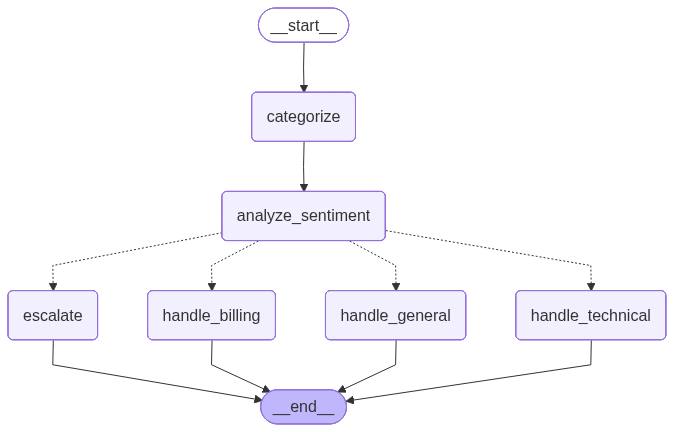

In [15]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [16]:
def run_customer_support(query: str) -> Dict[str, str]:
  results = app.invoke({"query": query})
  return {
      "category":results['category'],
      "sentiment":results['sentiment'],
      "response": results['response']
  }

In [21]:
query = "The price value in my invoice is wrong"
result = run_customer_support(query)
print("\n\n\nComputed Result")
print(f"\nQuery: {query}")
print(f"\n\nCategory: {result['category']}")
print(f"\n\nSentiment: {result['sentiment']}")
print(f"\n\nResponse: {result['response']}")
print("\n")


Category:I would categorize the query as: Billing

Analyzing the sentiment : 

Sentiment : The sentiment of the customer query is: Negative

Escalating Query



Computed Result

Query: The price value in my invoice is wrong


Category: I would categorize the query as: Billing


Sentiment: The sentiment of the customer query is: Negative


Response: This query has been escalate to a human agent due to its negative sentiment




In [24]:
query = "my iphone isnt working"
result = run_customer_support(query)
print("\n\n\nComputed Result")
print(f"\nQuery: {query}")
print(f"\n\nCategory: {result['category']}")
print(f"\n\nSentiment: {result['sentiment']}")
print(f"\n\nResponse: {result['response']}")
print("\n")


Category:I would categorize the query as "General". The reason is that the query is not specific to a technical aspect or a billing issue, but rather a general problem statement about a product (iPhone) not working. It's a question that could be answered with general troubleshooting advice or possibly a request for support, but it's not related to any technical or billing context.

Analyzing the sentiment : 

Sentiment : The sentiment of the customer query "my iPhone isn't working" is 'Negative'.

Escalating Query



Computed Result

Query: my iphone isnt working


Category: I would categorize the query as "General". The reason is that the query is not specific to a technical aspect or a billing issue, but rather a general problem statement about a product (iPhone) not working. It's a question that could be answered with general troubleshooting advice or possibly a request for support, but it's not related to any technical or billing context.


Sentiment: The sentiment of the customer